In [1]:
##########################################################################
# Created on Sat Nov 20 17:22:45 2021                                    #
# Python for Financial Analysis and Risk Management                      #
# @author: Meng Lipeng (FRM, CFA)                                        #
##########################################################################

# 14.2.1.CB intro

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/custom_python/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'Quantity or Amount')

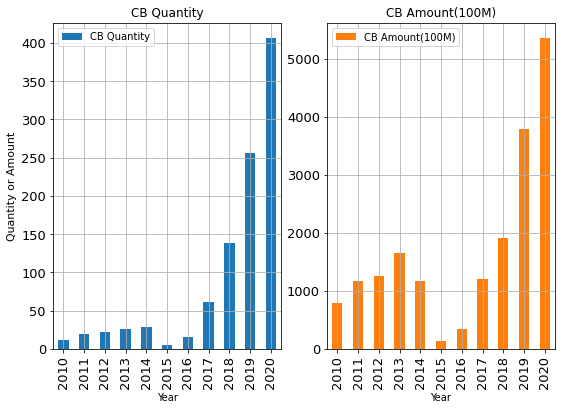

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data_CB=pd.read_excel('CB quantity and amount(2010-2020).xlsx',engine='openpyxl',sheet_name="Sheet1",header=0,index_col=0)
#data_CB.head()
data_CB.plot(kind='bar',subplots=True,layout=(1,2),figsize=(9,6),grid=True,fontsize=13)
plt.subplot(1,2,1)
plt.ylabel('Quantity or Amount',fontsize=11)

# 14.2.2.CB pricing

### Modified binomial tree model

$$u=e^{\sqrt{(\sigma^2-\lambda)\Delta t}}\tag{14-4}$$
$$d=\frac{1}{u}\tag{14-5}$$
$$P_u=\frac{e^{r\Delta t}-de^{-\lambda \Delta t}}{u-d}\tag{14-6}$$
$$P_d=\frac{ue^{-\lambda \Delta t}-e^{r\Delta t}}{u-d}\tag{14-7}$$
$$PD=1-P_u-P_d=1-e^{-\lambda \Delta t}\tag{14-8}$$
where,\
$\lambda$:Annualized probability of default(continuous compound)

For price on every node of binomial tree,\
$$V=max[min(Q_1,Q_2),Q_3]\tag{14-9}$$
where,\
$Q_1$:Bond price using reverse induction method\
$Q_2$:Callable bond price\
$Q_3$:Converted Stock price 

### Implementation

Put underlying asset price in an upper triangular matrix\
$$S=\begin{bmatrix}
S_0    & S_0u   & \ldots & S_0u^{N-1} & S_0u^N \\
0      & S_0d   & \ldots & S_0u^{N-2} & S_0u^{N-1}d \\
\vdots & \vdots & \ddots & \vdots     & \vdots \\
0      & 0      & \ldots & S_0d^{N-1} & S_0ud^{N-1} \\
0      & 0      & \ldots & 0          & S_0d^{N}
\end{bmatrix}\tag{14-10}$$

CB price when expires\
$$C=\begin{bmatrix}
0      & 0      & \ldots & 0          & max[min(Q_1,Q_2),XS_0u^N] \\
0      & 0      & \ldots & 0          & max[min(Q_1,Q_2),XS_0u^{N-1}d] \\
\vdots & \vdots & \ddots & \vdots     & \vdots \\
0      & 0      & \ldots & 0          & max[min(Q_1,Q_2),XS_0ud^{N-1}] \\
0      & 0      & \ldots & 0          & max[min(Q_1,Q_2),XS_0d^N]
\end{bmatrix}\tag{14-11}$$
where,\
$X$:conversion ratio

In [14]:
def value_CB(S,sigma,par,X,Lambda,r,R,Q2,T,N):
    '''Define a function to calculate CB price using N steps binomial tree. Assuming zero rate bond.
    S:underlying price at t0
    sigma:volatility of stock return(annualized)
    par:par of CB
    X:conversion ratio
    Lambda:Annualized probability of default(continuous compound)
    r:risk free rate(continuous compound)
    R:Recovery rate when deault
    T:tenor in year
    N:number of step in the BTM model'''

    import numpy as np
    
    # Step1:Calculate relevant parameters
    t=T/N
    u=np.exp(np.sqrt((pow(sigma,2)-Lambda)*t))
    d=1/u
    Pu=(np.exp(r*t)-d*np.exp(-Lambda*t))/(u-d)
    Pd=(u*np.exp(-Lambda*t)-np.exp(r*t))/(u-d)
    P_default=1-np.exp(-Lambda*t)
    D_value=par*R
    CB_matrix=np.zeros((N+1,N+1))
    
    # Step2:Calculate the stock price and bond value at the CB maturity node
    N_list=np.arange(0,N+1)
    S_end=S*pow(u,N-N_list)*pow(d,N_list)
    Q1=par
    Q3=X*S_end
    CB_matrix[:,-1]=np.maximum(np.minimum(Q1,Q2),Q3)
    
    #Step3:Calculate the stock price and bond value at the non maturity node of the option
    i_list=list(range(0,N))
    i_list.reverse()
    for i in i_list:
        j_list=np.arange(i+1)
        Si=S*pow(u,i-j_list)*pow(d,j_list)
        Q1=np.exp(-r*t)*(Pu*CB_matrix[:i+1,i+1]+Pd*CB_matrix[1:i+2,i+1]+P_default*D_value)#No converted,No called
        Q3=X*Si #Converted
        CB_matrix[:i+1,i]=np.maximum(np.minimum(Q1,Q2),Q3)
    V0=CB_matrix[0,0]
    
    return V0

In [16]:
tenor=9/12
step1=3

S0=50
sigma_A=0.2
par_CB=100
share=2
Lambda_A=0.01
rate=0.05
R_A=0.4
Q2_A=110

V1_CB=value_CB(S=S0,sigma=sigma_A,par=par_CB,X=share,Lambda=Lambda_A,r=rate,R=R_A,Q2=Q2_A,T=tenor,N=step1)
print('CB price using 3-steps binomial tree is ',round(V1_CB,4))

CB price using 3-steps binomial tree is  104.2012


In [17]:
step2=100
V2_CB=value_CB(S=S0,sigma=sigma_A,par=par_CB,X=share,Lambda=Lambda_A,r=rate,R=R_A,Q2=Q2_A,T=tenor,N=step2)
print('CB price using 100-steps binomial tree is ',round(V2_CB,4))

CB price using 100-steps binomial tree is  103.69


In [18]:
step3=300
V3_CB=value_CB(S=S0,sigma=sigma_A,par=par_CB,X=share,Lambda=Lambda_A,r=rate,R=R_A,Q2=Q2_A,T=tenor,N=step3)
print('CB price using 300-steps binomial tree is ',round(V3_CB,4))

CB price using 300-steps binomial tree is  103.5598
